In [1]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np
import copy
import random
import mlflow

In [2]:
#https://dagshub.com/kewinlee123/deepfake_detection.mlflow
# export MLFLOW_TRACKING_URI=https://dagshub.com/entbappy/chest-Disease-Classification-MLflow-DVC.mlflow

# export MLFLOW_TRACKING_USERNAME=entbappy 

# export MLFLOW_TRACKING_PASSWORD=yourotken


mlflow.set_tracking_uri("https://dagshub.com/kewinlee123/deepfake_detection.mlflow")
os.environ['MLFLOW_TRACKING_USERNAME'] = 'kewinlee123'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4a000f6d1d5d973e568803cc5a70bd9108c53cb9'
#mlflow.set_experiment("/deepfake_detection.mlflow")



In [3]:
#Check if the file is corrupted or not
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count = 20
      video_path = vid_path
      frames = []
      a = int(100/count)
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('\\')[-1]
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames
#extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path)
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

im_size = 112
mean = [0.485, 0.456, 0.406] #standard value for normalization by pytorch
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([ #convert each frame into tensor
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
video_files =  glob.glob('./Face_Crop_Small/*.mp4')
#video_fil =  glob.glob('/Face_Crop/*.mp4')

print("Total no of videos :" , len(video_files))
print(video_files)
count = 0;
for i in video_files:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_files) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_files) - count))

Total no of videos : 2
['./Face_Crop_Small\\id0_0000.mp4', './Face_Crop_Small\\id1_id0_0000.mp4']
0


In [4]:
#to load preprocessod video to memory
#video_files =  glob.glob('./Face_Crop/*.mp4')
video_files =  glob.glob('./Face_Crop_Small/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [151, 151]
Total no of video:  2
Average frame per video: 151.0


In [5]:
# load the video name and labels from csv

class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        video_title = video_path.split('\\')[-1]
        video_title_sz=len(video_title.split('_'))
        temp_video = video_title
        label=1
        #label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(video_title_sz == 3):
          label = 0
        if(video_title_sz == 2):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]

        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [6]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  #lab = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    video_title =i.split('\\')[-1]
    video_title_sz=len(video_title.split('_'))
    temp_video =video_title

    #label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(video_title_sz == 3):
      fake+=1
    if(video_title_sz == 2):
      real+=1
  return real,fake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train :  1
test :  1
TRAIN:  Real: 0  Fake: 1
TEST:  Real: 1  Fake: 0


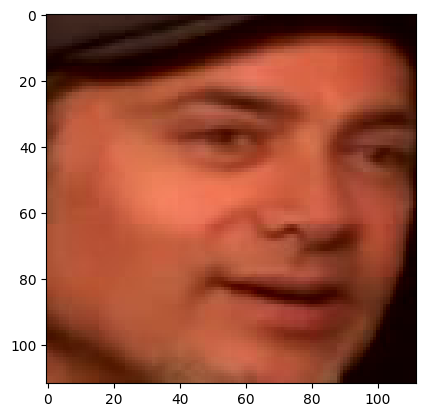

In [7]:
# load the labels and video in data loader
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
#labels = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
#print(labels)
labels=[]

#80 20 split
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

batch_size=4
train_data = video_dataset(train_videos,labels,sequence_length = 20,transform = train_transforms) #First 20 frames will be passed to model for training
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 20,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True,num_workers = 0) #earlier num works 4 for multiprocessing 
valid_loader = DataLoader(val_data,batch_size = batch_size,shuffle = True,num_workers = 0) #earlier num works 4 for multiprocessing 
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [8]:
#Model with required features
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [9]:
model = Model(2).cuda() #Download model
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

C:\Users\PRANAY\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PRANAY\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#Training and testing functions
import torch
from torch.autograd import Variable
import time
import os
import sys

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad() ## WHY SET TO ZERO ?
        loss.backward()
        optimizer.step()      
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
        
        step=i // 100 * (epoch + 1) #batch // 100 * (epoch + 1)
        mlflow.log_metric("loss", f"{losses.avg:2f}", step=step)
        mlflow.log_metric("accuracy", f"{accuracies.avg:2f}", step=step)
        
  
    torch.save(model.state_dict(),'./trained-model.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        mlflow.log_metric("eval_loss", f"{losses.avg:2f}", step=epoch)
        mlflow.log_metric("eval_accuracy", f"{accuracies.avg:2f}", step=epoch)
    
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [11]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [12]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [13]:
#Call training functions and testing in each epoch

from sklearn.metrics import confusion_matrix

with mlflow.start_run() as run:
    #learning rate
    lr = 1e-5
    #number of epochs
    num_epochs = 20
    weight_decay=1e-5
   

    
    optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = weight_decay)

    
    
    #class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
    #criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    train_loss_avg =[]
    train_accuracy = []
    test_loss_avg = []
    test_accuracy = []
    params = {
        "epochs": num_epochs,
        "learning_rate": lr,
        "batch_size": batch_size,
        "loss_function": nn.CrossEntropyLoss().__class__.__name__,
        "metric_function": AverageMeter().__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)
    
    for epoch in range(1,num_epochs+1):
        l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
        train_loss_avg.append(l)
        train_accuracy.append(acc)
        
        true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
        test_loss_avg.append(tl)
        test_accuracy.append(t_acc)
        torch.cuda.empty_cache()
    plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
    plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
    print(confusion_matrix(true,pred))
    print_confusion_matrix(true,pred)
    
     # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

[Epoch 1/20] [Batch 0 / 1] [Loss: 0.679445, Acc: 100.00%]Testing
[Batch 0 / 1]  [Loss: 0.747538, Acc: 0.00%]
Accuracy 0.0
[Epoch 2/20] [Batch 0 / 1] [Loss: 0.667731, Acc: 100.00%]

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.cuda.empty_cache()